# Imports

In [11]:
# Ignore Future warnings from tensorflow
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)

import tensorflow as tf
from tensorflow_probability import edward2 as ed
import numpy as np
import matplotlib.pyplot as plt
import inferpy as inf
from inferpy.data import mnist
import pandas as pd
import sys


ModuleNotFoundError: No module named 'imblearn'

# Constants

In [2]:
# Training epochs
num_epochs = 3000
# Learning rate for Adam optimizer
learning_rate = 0.01
# number of observations (dataset size)
N = 10000
# digits considered
DIG = [0,1,2]
# Dimension of reduced  space
K = 2
# seed
tf.set_random_seed(1234)

# Data Samples

MNIST dataset containg handwritten digits will be used. In particular we might obtain the data from the ``inferpy`` package:

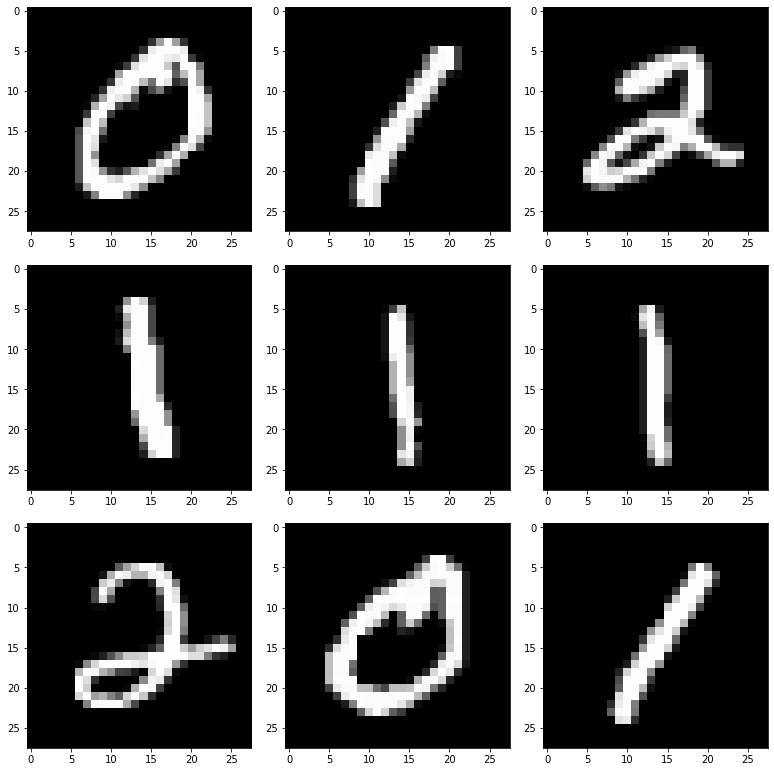

In [3]:
# load the data
(X_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)

# plot digits example
mnist.plot_digits(X_train, grid=[3,3])

# Models definition

The input parameters are: $k$ is the latent dimension, $d$ is the data-dimension.

In [4]:
# Parametric model
@inf.probmodel
def pca(k,d):
    w = inf.Normal(loc=tf.zeros([k,d]),
                   scale=1, name="w")                   # shape = [k,d]
    w0 = inf.Normal(loc=tf.zeros([d]),
                    scale=1, name="w0")                 # shape = [d]
    with inf.datamodel():
        z = inf.Normal(tf.zeros([k]),1, name="z")       # shape = [N,k]
        x = inf.Normal( z @ w + w0, 1, name="x")        # shape = [N,d]

In [5]:
# Variational model
@inf.probmodel
def Q(k,d):
    qw_loc = inf.Parameter(tf.zeros([k,d]), name="qw_loc")
    qw_scale = tf.math.softplus(inf.Parameter(tf.ones([k,d]), name="qw_scale"))
    qw = inf.Normal(qw_loc, qw_scale, name="w")

    qw0_loc = inf.Parameter(tf.ones([d]), name="qw0_loc")
    qw0_scale = tf.math.softplus(inf.Parameter(tf.ones([d]), name="qw0_scale"))
    qw0 = inf.Normal(qw0_loc, qw0_scale, name="w0")
    
    with inf.datamodel():
        qz_loc = inf.Parameter(np.zeros([k]), name="qz_loc")
        qz_scale = tf.math.softplus(inf.Parameter(tf.ones([k]), name="qz_scale"))
        qz = inf.Normal(qz_loc, qz_scale, name="z")

# Training

In [6]:
# original space dimension
D = np.shape(X_train)[-1]

# create an instance of the P model and the Q model
m = pca(K,D)
q = Q(K,D)

# Define optimizer 
optimizer = tf.train.AdamOptimizer(learning_rate)
# Define inference object
VI = inf.inference.VI(q, optimizer=optimizer, epochs=num_epochs)

In [7]:
# Start training
m.fit({"x": X_train}, VI)        


 0 epochs	 28612401152.0....................
 200 epochs	 24856932352.0....................
 400 epochs	 18839617536.0....................
 600 epochs	 16649962496.0....................
 800 epochs	 16054537216.0....................
 1000 epochs	 15810502656.0....................
 1200 epochs	 15229768704.0....................
 1400 epochs	 13933741056.0....................
 1600 epochs	 13109009408.0....................
 1800 epochs	 12831090688.0....................
 2000 epochs	 12737256448.0....................
 2200 epochs	 12698867712.0....................
 2400 epochs	 12680803328.0....................
 2600 epochs	 12668652544.0....................
 2800 epochs	 12657531904.0....................

Print loss function evolution

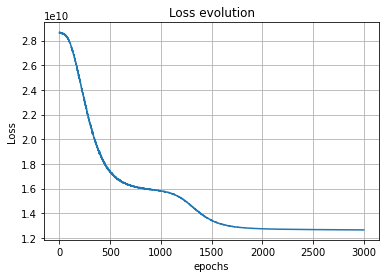

In [8]:
L = VI.losses
plt.plot(range(len(L)), L)

plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss evolution')
plt.grid(True)
plt.show()

# Results

After the inference, we can plot the hidden representation:

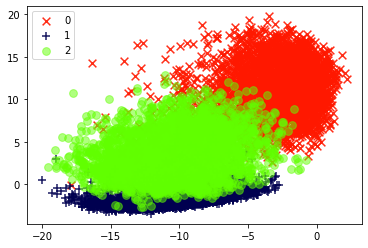

In [9]:
# Get a sample from the posterior
post = {"z": m.posterior("z").sample()}

# Set markers and colors for each digit
markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()


for c in range(0, len(DIG)):
    col = colors[c]
    plt.scatter(post["z"][y_train == DIG[c], 0], 
                post["z"][y_train == DIG[c], 1], 
                color=col,
                label=DIG[c], 
                marker=markers[c], 
                alpha=transp[c], 
                s=60)
    plt.legend()

We may try to reconstruct the data from the hidden space using `posterior_predictive`.

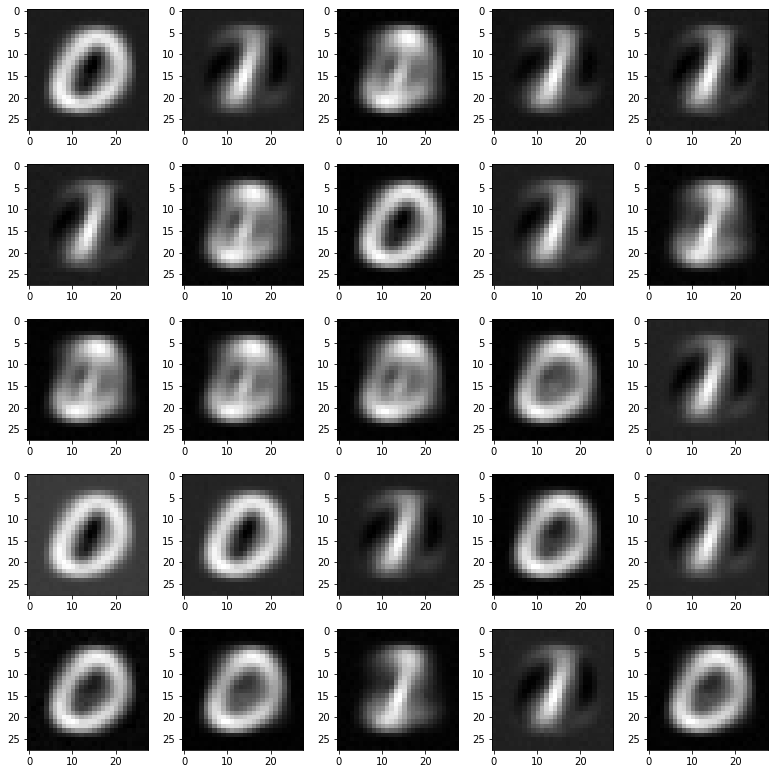

In [10]:
x_gen = m.posterior_predictive('x', data=post).sample()

# plot the digits
mnist.plot_digits(x_gen, grid=[5,5])